# Variability and Internal Consistency

### Imports

In [1]:
import os
import re
import glob
import os
import ast
import os.path as op
from collections import defaultdict
from copy import deepcopy
import copy

import pickle
from time import time
import pywt
import mne
import scipy
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import cesium.featurize
from plotly.subplots import make_subplots
from ipywidgets import Dropdown, FloatRangeSlider, IntSlider, FloatSlider, interact
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import TransformerMixin, BaseEstimator

import sys

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVR
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

from rumination_experiment_transformers_averaged_CDS import *

import warnings

warnings.filterwarnings("ignore")

---
## Load data

Loading EEG data and questionnaire data. By default create_df_data loads all info from given file but one can specify it by passing a list of desired labels from csv file.

In [2]:
# paths TODO
dir_path = os.path.dirname(os.path.abspath(""))

In [3]:
tmin, tmax = -0.101562, 0.5937525  # Start and end of the segments
signal_frequency = 256
ERROR = 0
CORRECT = 1
ALL = 2
random_state = 0

In [4]:
def create_df_data(
    test_participants=False,
    test_epochs=False,
    info_filename=None,
    info="all",
    personal=True,
):
    """Loads data for all participants and create DataFrame with optional additional info from given .csv file.
CenteredSignalAfterBaseline3CenteredSignalAfterBaseline3CenteredSignalAfterBaseline3
    On default, loads a train set: chooses only 80% of participants
    and for each of them chooses 80% of epochs.
    It will choose them deterministically.

    Participants with less than 10 epochs per condition are rejected.

    If test_participants is set to True, it will load remaining 20% of participants.
    If test_epochs is set to True, it will load remaining 20% of epochs.
    Test epochs are chronologically after train epochs,
    because it reflects real usage (first callibration and then classification).

    Parameters
    ----------
    test_participants: bool
        whether load data for training or final testing.
        If true load participants data for testing.
    test_epochs: bool
        whether load data for training or final testing.
        If true load epochs of each participants data for testing.
    info_filename: String | None
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters
    personal: bool
        whether a model will be both trained and tested on epochs from one person
        if false, person's epochs aren't split into test and train


    Returns
    -------
    go_nogo_data_df : pandas.DataFrame

    """
    print(os.path.abspath(""))
    dir_path = os.path.dirname(os.path.abspath(""))
    print(dir_path)
    header_files_glob = os.path.join(dir_path, "data/responses_100_600/*.vhdr")
    header_files = glob.glob(header_files_glob)

    header_files = sorted(header_files)
    go_nogo_data_df = pd.DataFrame()

    # cut 20% of data for testing
    h_train, h_test = train_test_split(header_files, test_size=0.3, random_state=0)
    
    print(f"train size: {len(h_train)} ; test size: {len(h_test)}")

    if test_participants:
        header_files = h_test
    else:
        header_files = h_train

    for file in header_files:
        #  load eeg data for given participant
        participant_epochs = load_epochs_from_file(file)

        # and compute participant's id from file_name
        participant_id = re.match(r".*_(\w+).*", file).group(1)

        error = participant_epochs["error_response"]._data
        correct = participant_epochs["correct_response"]._data

        # exclude those participants who have too few samples
        if len(error) < 5 or len(correct) < 5:
            # not enough data for this participant
            continue

        # construct dataframe for participant with: id|epoch_data|response_type|additional info...
        participant_df = create_df_from_epochs(
            participant_id, participant_epochs, info_filename, info
        )
        print(participant_id)
        go_nogo_data_df = go_nogo_data_df.append(participant_df, ignore_index=True)

    return go_nogo_data_df

In [5]:
def create_df_from_epochs(id, participant_epochs, info_filename, info):
    """Create df for each participant. DF structure is like: {id: String ; epoch: epoch_data ; marker: 1.0|0.0}
    1.0 means correct and 0.0 means error response.
    Default info extracted form .csv file is 'Rumination Full Scale' and participants' ids.
    With this info df structure is like:
    {id: String ; epoch: epoch_data ; marker: 1.0|0.0 ; File: id ; 'Rumination Full Scale': int}

    Parameters
    ----------
    id: String
        participant's id extracted from filename
    correct: array
        correct responses' data
    error: array
        error responses' data
    info_filename: String
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters

    Returns
    -------
    participant_df : pandas.DataFrame

    """
    participant_df = pd.DataFrame()
    info_df = pd.DataFrame()

    # get additional info from file
    if info_filename is not None:
        if info == "all":
            rumination_df = pd.read_csv(info_filename)
        else:
            rumination_df = pd.read_csv(info_filename, usecols=["Demo_kod"] + info)
        info_df = (
            rumination_df.loc[rumination_df["Demo_kod"] == id]
            .reset_index()
            .drop("index", axis=1)
        )

#     for epoch in correct:
#         epoch_df = pd.DataFrame(
#             {"id": [id], "epoch": [epoch], "marker": [CORRECT]}
#         ).join(info_df)
#         participant_df = participant_df.append(epoch_df, ignore_index=True)

#     for epoch in error:
#         epoch_df = pd.DataFrame({"id": [id], "epoch": [epoch], "marker": [ERROR]}).join(
#             info_df
#         )
#         participant_df = participant_df.append(epoch_df, ignore_index=True)
        
#     print(participant_epochs)
        
    epoch_df = pd.DataFrame({"id": [id], "epoch": [participant_epochs], "marker": [ALL]}).join(
            info_df
        )
    participant_df = participant_df.append(epoch_df, ignore_index=True)

    return participant_df

In [6]:
def load_epochs_from_file(file, reject_bad_segments="auto", mask=None):
    """Load epochs from a header file.

    Args:
        file: path to a header file (.vhdr)
        reject_bad_segments: 'auto' means that bad segments are rejected automatically.

    Returns:
        mne Epochs

    """
    # Import the BrainVision data into an MNE Raw object
    raw = mne.io.read_raw_brainvision(file)

    # Construct annotation filename
    annot_file = file[:-4] + "vmrk"

    # Read in the event information as MNE annotations
    annotations = mne.read_annotations(annot_file)

    # Add the annotations to our raw object so we can use them with the data
    raw.set_annotations(annotations)

    # Map with response markers only
    event_dict = {
        "Stimulus/RE*ex*1_n*1_c_1*R*FB": 10004,
        "Stimulus/RE*ex*1_n*1_c_1*R*FG": 10005,
        "Stimulus/RE*ex*1_n*1_c_2*R": 10006,
        "Stimulus/RE*ex*1_n*2_c_1*R": 10007,
        "Stimulus/RE*ex*2_n*1_c_1*R": 10008,
        "Stimulus/RE*ex*2_n*2_c_1*R*FB": 10009,
        "Stimulus/RE*ex*2_n*2_c_1*R*FG": 10010,
        "Stimulus/RE*ex*2_n*2_c_2*R": 10011,
    }

    # Map for merged correct/error response markers
    merged_event_dict = {"correct_response": 0, "error_response": 1}

    # Reconstruct the original events from Raw object
    events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

    # Merge correct/error response events
    merged_events = mne.merge_events(
        events,
        [10004, 10005, 10009, 10010],
        merged_event_dict["correct_response"],
        replace_events=True,
    )
    merged_events = mne.merge_events(
        merged_events,
        [10006, 10007, 10008, 10011],
        merged_event_dict["error_response"],
        replace_events=True,
    )

    epochs = []
    bads = []
    this_reject_by_annotation = True

    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=merged_events,
        event_id=merged_event_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=this_reject_by_annotation,
        preload=True,
    )
    
    return epochs

#### Read the training data

In [7]:
df_name = "go_nogo_100_600_df_3-5_all_scales"
pickled_data_filename = "../data/responses_100_600_pickled/" + df_name + ".pkl"
info_filename = "../data/scales/all_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_df = pd.read_pickle(pickled_data_filename)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_df.name = df_name
    # save loaded data into a pickle file
    epochs_df.to_pickle("../data/responses_100_600_pickled/" + epochs_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [8]:
df_name = "go_nogo_500_300_df_3-5_all_scales"
pickled_data_filename = "../data/responses_500_300_pickled/" + df_name + ".pkl"
info_filename = "../data/Demographic_Questionnaires_Behavioral_Results_N=163.csv"

# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_df_3 = pd.read_pickle(pickled_data_filename)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_df_3 = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_df_3.name = df_name
    # save loaded data into a pickle file
    epochs_df_3.to_pickle("../data/responses_500_300_pickled/" + epochs_df_3.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


#### Read the testing data

In [9]:
df_name = "go_nogo_100_600_test_df_3-5_all_scales"
pickled_data_filename = "../data/responses_100_600_pickled/" + df_name + ".pkl"
info_filename = "../data/scales/all_scales.csv"

# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_test_df = pd.read_pickle(pickled_data_filename)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_test_df = create_df_data(
        test_participants=True, info="all", personal=False, info_filename=info_filename
    )
    epochs_test_df.name = df_name
    # save loaded data into a pickle file
    epochs_test_df.to_pickle("../data/responses_100_600_pickled/" + epochs_test_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [10]:
df_name = "go_nogo_500_300_test_df_3-5_all"
pickled_data_filename = "../data/responses_500_300_pickled/" + df_name + ".pkl"
info_filename = "../data/Demographic_Questionnaires_Behavioral_Results_N=163.csv"

# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_test_df_3 = pd.read_pickle(pickled_data_filename)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_test_df_3 = create_df_data(
        test_participants=True, info="all", personal=False, info_filename=info_filename
    )
    epochs_test_df_3.name = df_name
    # save loaded data into a pickle file
    epochs_test_df_3.to_pickle("../data/responses_500_300_pickled/" + epochs_test_df_3.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [11]:
X_train_df_100 = epochs_df
X_test_df_100 = epochs_test_df

X_train_df_500 = epochs_df_3
X_test_df_500 = epochs_test_df_3

---

In [63]:
# condition = 'ern' | 'pe'
condition = 'pe'

## Variability estimates depending on different choices in pre-processing


### Between subject variability (SD)

In [64]:
between_df = pd.DataFrame({'pipeline': [], 'values': []})

In [65]:
# default ROIs for ERN and Pe

roi = [
    "Fpz",
    "AFz", 
    "F1","Fz", "F2",
    "FC1", "FCz", "FC2",
    "C1","Cz","C2",
    "CP1", "CPz", "CP2",
    "P1", "Pz", "P2",
] if condition == 'pe' else [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

1. Test lowpass filters: 40 | 30 | 20 | 15

        - reference: Mastoids;
        - baseline: -100 to 0 ms;
        - spatial filter (PCA) for default ERN ROI

In [66]:
for cutoff in [40, 30, 20, 15]:    
    
    X_train_df_100copy = pd.DataFrame(copy.deepcopy(X_train_df_100.to_dict()))
    
    pipeline_name = str(cutoff) + ' Hz'
    
    ern_features = Pipeline(steps=[
                                    ("ern_data_extraction", ErnTransformer()),
                                    ("ern_amplitude", ErnAmplitude2()),
                    ])


    pe_features = Pipeline(steps = [
                                    ("pe_data_extraction", PeTransformer(start_pe_bin=3, stop_pe_bin=8)),
                                    ("pe_amplitude", PeAmplitude2()),
                    ])

    ern_pe_features = FeatureUnion([("pe_features", pe_features)]) if condition == 'pe' else FeatureUnion([("ern_features", ern_features)])

    x_pre = Pipeline([
                ("channels_extraction",PickChannels(channels_list=roi)),
                ("average", Evoked()),
                ('extract_data', ExtractData()),
                ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
                ("spatial_filter",PCA(n_components=4, random_state=random_state)),
                ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=181)),
                ("lowpass_filter", LowpassFilter2(cutoff=cutoff)),
                ("binning", BinTransformer(step=12)),
                ("centering", CenteredSignalAfterBaseline3()),
                ("features", ern_pe_features),
    ]).fit_transform(X_train_df_100copy)

    x_feature_100_between = np.sum(x_pre, axis=1)
    x_100_std_between = np.std(x_feature_100_between, axis=0)

    values = x_feature_100_between.flatten().tolist()
    names = [pipeline_name] * len(x_feature_100_between)

    temp_df = pd.DataFrame(zip(names, values), columns=['pipeline', 'values'])

    between_df = between_df.append(temp_df, ignore_index=True)   

(96, 17, 181)
(96, 17, 181)
(96, 17, 181)
(96, 17, 181)


2. Test references: mastoids | average

        - lowpass: 40 Hz;
        - baseline: -100 to 0 ms;
        - spatial filter (PCA) for default ERN ROI

In [67]:
cutoff = 40

In [68]:
X_train_df_100copy = pd.DataFrame(copy.deepcopy(X_train_df_100.to_dict()))

pipeline_name = 'Mastoids'

ern_features = Pipeline(steps=[
                                ("ern_data_extraction", ErnTransformer()),
                                ("ern_amplitude", ErnAmplitude2()),
                ])


pe_features = Pipeline(steps = [
                                ("pe_data_extraction", PeTransformer(start_pe_bin=3, stop_pe_bin=8)),
                                ("pe_amplitude", PeAmplitude2()),
                ])

ern_pe_features = FeatureUnion([("pe_features", pe_features)]) if condition == 'pe' else FeatureUnion([("ern_features", ern_features)])

x_pre = Pipeline([
                ("channels_extraction",PickChannels(channels_list=roi)),
                ("average", Evoked()),
                ('extract_data', ExtractData()),
                ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
                ("spatial_filter",PCA(n_components=4, random_state=random_state)),
                ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=181)),
                ("lowpass_filter", LowpassFilter2(cutoff=cutoff)),
                ("binning", BinTransformer(step=12)),
                ("centering", CenteredSignalAfterBaseline3()),
                ("features", ern_pe_features),
]).fit_transform(X_train_df_100copy)

x_feature_100_between = np.sum(x_pre, axis=1)
x_100_std_between = np.std(x_feature_100_between, axis=0)

values = x_feature_100_between.flatten().tolist()
names = [pipeline_name] * len(x_feature_100_between)

temp_df = pd.DataFrame(zip(names, values), columns=['pipeline', 'values'])

between_df = between_df.append(temp_df, ignore_index=True)

################################################################################################

X_train_df_100copy = pd.DataFrame(copy.deepcopy(X_train_df_100.to_dict()))

pipeline_name = 'Average'

ern_features = Pipeline(steps=[
                                ("ern_data_extraction", ErnTransformer()),
                                ("ern_amplitude", ErnAmplitude2()),
                ])


pe_features = Pipeline(steps = [
                                ("pe_data_extraction", PeTransformer(start_pe_bin=3, stop_pe_bin=8)),
                                ("pe_amplitude", PeAmplitude2()),
                ])

ern_pe_features = FeatureUnion([("pe_features", pe_features)]) if condition == 'pe' else FeatureUnion([("ern_features", ern_features)])


x_pre = Pipeline([
                ("channels_extraction",PickChannels(channels_list=roi)),
                ("reference_to_avg", ReferenceToAverage()),
                ("average", Evoked()),
                ('extract_data', ExtractData()),
                ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
                ("spatial_filter",PCA(n_components=4, random_state=random_state)),
                ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=181)),
                ("lowpass_filter", LowpassFilter2(cutoff=cutoff)),
                ("binning", BinTransformer(step=12)),
                ("centering", CenteredSignalAfterBaseline3()),
                ("features", ern_pe_features),
]).fit_transform(X_train_df_100copy)

x_feature_100_between = np.sum(x_pre, axis=1)
x_100_std_between = np.std(x_feature_100_between, axis=0)

values = x_feature_100_between.flatten().tolist()
names = [pipeline_name] * len(x_feature_100_between)

temp_df = pd.DataFrame(zip(names, values), columns=['pipeline', 'values'])

between_df = between_df.append(temp_df, ignore_index=True) 

(96, 17, 181)
(96, 17, 181)


3. Test baselines: -100 to 0 ms | -500 to -300 ms

        - reference: Mastoids;
        - lowpass: 40 Hz;
        - spatial filter (PCA) for default ERN ROI

In [69]:
X_train_df_100copy = pd.DataFrame(copy.deepcopy(X_train_df_100.to_dict()))

pipeline_name = '-100:0'

ern_features = Pipeline(steps=[
                                ("ern_data_extraction", ErnTransformer()),
                                ("ern_amplitude", ErnAmplitude2()),
                ])


pe_features = Pipeline(steps = [
                                ("pe_data_extraction", PeTransformer(start_pe_bin=3, stop_pe_bin=8)),
                                ("pe_amplitude", PeAmplitude2()),
                ])

ern_pe_features = FeatureUnion([("pe_features", pe_features)]) if condition == 'pe' else FeatureUnion([("ern_features", ern_features)])


x_pre = Pipeline([
                ("channels_extraction",PickChannels(channels_list=roi)),
                ("average", Evoked()),
                ('extract_data', ExtractData()),
                ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
                ("spatial_filter",PCA(n_components=4, random_state=random_state)),
                ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=181)),
                ("lowpass_filter", LowpassFilter2(cutoff=cutoff)),
                ("binning", BinTransformer(step=12)),
                ("centering", CenteredSignalAfterBaseline3()),
                ("features", ern_pe_features),
]).fit_transform(X_train_df_100copy)

x_feature_100_between = np.sum(x_pre, axis=1)
x_100_std_between = np.std(x_feature_100_between, axis=0)

values = x_feature_100_between.flatten().tolist()
names = [pipeline_name] * len(x_feature_100_between)

temp_df = pd.DataFrame(zip(names, values), columns=['pipeline', 'values'])

between_df = between_df.append(temp_df, ignore_index=True) 

##########################################################################

X_train_df_500copy = pd.DataFrame(copy.deepcopy(X_train_df_500.to_dict()))

pipeline_name = '-500:-300'

ern_features = Pipeline(steps=[
                                ("ern_data_extraction", ErnTransformer()),
                                ("ern_amplitude", ErnAmplitude2()),
                ])


pe_features = Pipeline(steps = [
                                ("pe_data_extraction", PeTransformer(start_pe_bin=3, stop_pe_bin=8)),
                                ("pe_amplitude", PeAmplitude2()),
                ])

ern_pe_features = FeatureUnion([("pe_features", pe_features)]) if condition == 'pe' else FeatureUnion([("ern_features", ern_features)])


x_pre = Pipeline([
                ("channels_extraction",PickChannels(channels_list=roi)),
                ("average", Evoked()),
                ('extract_data', ExtractData()),
                ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
                ("spatial_filter",PCA(n_components=4, random_state=random_state)),
                ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=181)),
                ("lowpass_filter", LowpassFilter2(cutoff=cutoff)),
                ("binning", BinTransformer(step=12)),
                ("centering", CenteredSignalAfterBaseline3()),
                ("features", ern_pe_features),
]).fit_transform(X_train_df_500copy)

x_feature_500_between = np.sum(x_pre, axis=1)
x_500_std_between = np.std(x_feature_500_between, axis=0)

values = x_feature_500_between.flatten().tolist()
names = [pipeline_name] * len(x_feature_500_between)

temp_df = pd.DataFrame(zip(names, values), columns=['pipeline', 'values'])

between_df = between_df.append(temp_df, ignore_index=True)

(96, 17, 181)
(86, 17, 181)


### Plot resulst of between-subject variability tests

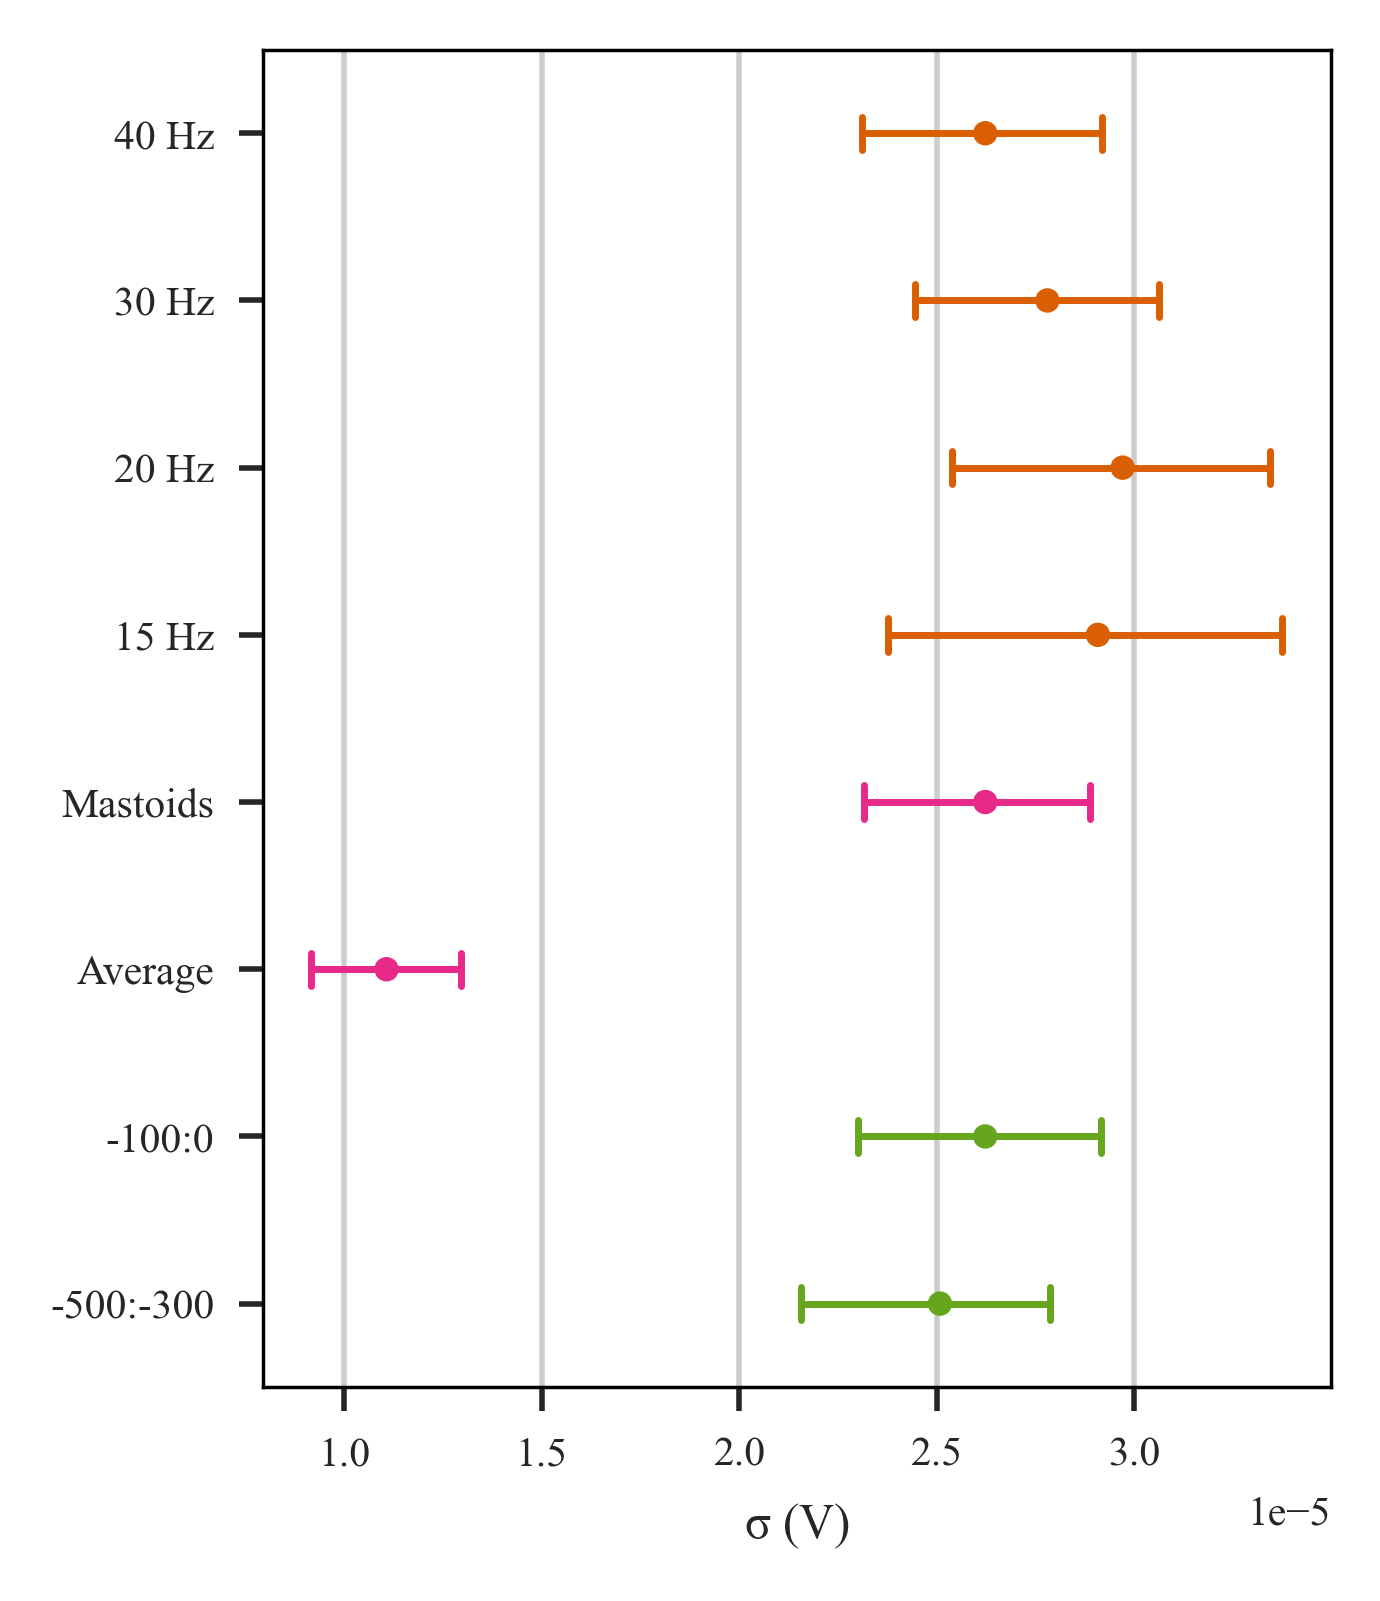

In [70]:
cm = 1/2.54
dpi = 500

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [7*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('Dark2')
colors = [
    pal.as_hex()[1], 
    pal.as_hex()[1], 
    pal.as_hex()[1], 
    pal.as_hex()[1], 
    pal.as_hex()[3], 
    pal.as_hex()[3], 
    pal.as_hex()[4], 
    pal.as_hex()[4],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
]


ax = sns.pointplot(
    x = 'values', 
    y = 'pipeline', 
    data = between_df, 
    orient='h',  
    palette=colors,
    errwidth=1,
    estimator=np.std, 
    ci=95,
    capsize=0.2,
    scale = 0.4

)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

ax.set_xlabel("$\mathregular{\sigma}$ (V)")
ax.set_ylabel('')

plt.show()

ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/between_subject_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

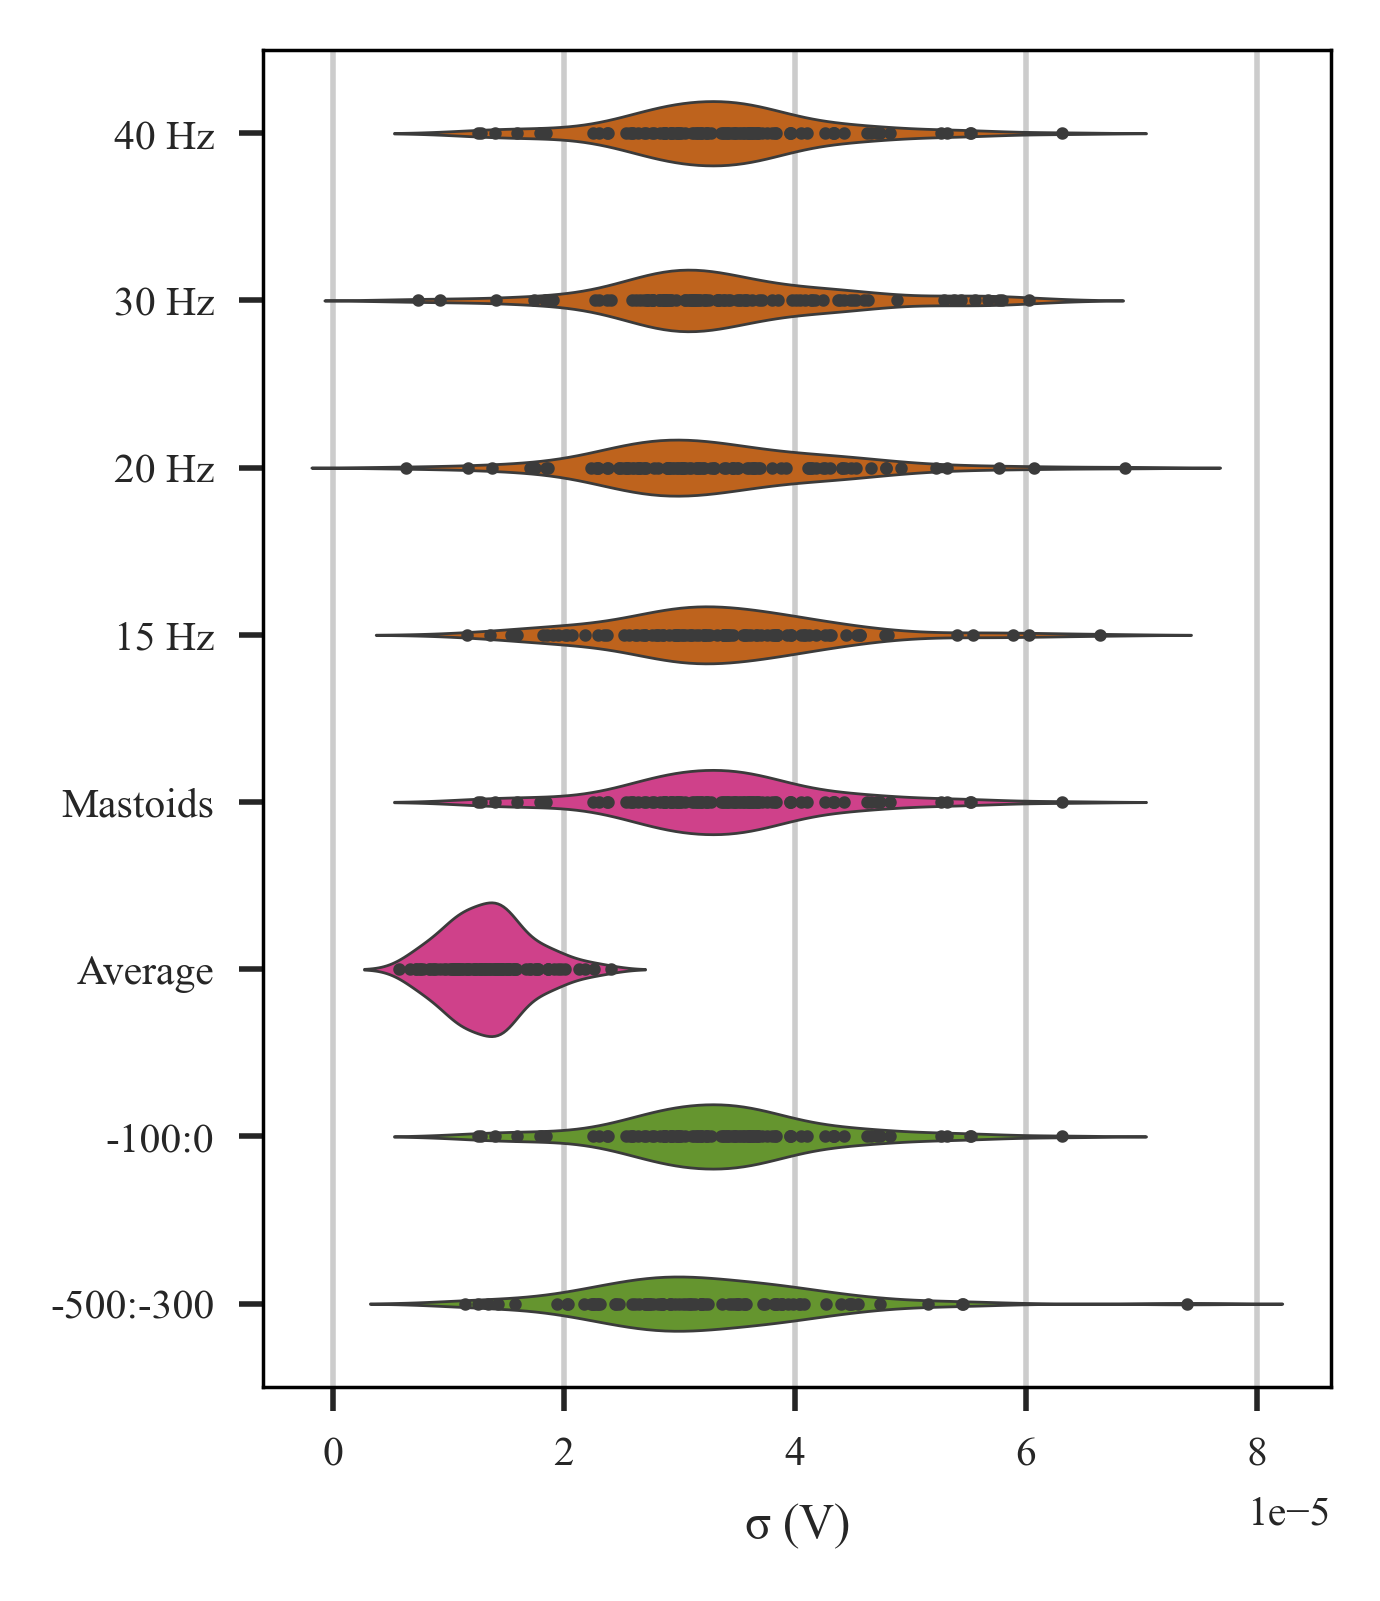

In [77]:
cm = 1/2.54
dpi = 500

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [7*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('Dark2')
colors = [
    pal.as_hex()[1], 
    pal.as_hex()[1], 
    pal.as_hex()[1], 
    pal.as_hex()[1], 
    pal.as_hex()[3], 
    pal.as_hex()[3], 
    # pal.as_hex()[2], 
    # pal.as_hex()[2],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
    pal.as_hex()[4],
    pal.as_hex()[4],
]


ax = sns.violinplot(
    x = 'values', 
    y = 'pipeline', 
    data = within_df, 
    orient='h',  
    inner="point", 
    cut=2, 
    # scale='count', 
    linewidth=0.4,
    palette=colors,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

ax.set_xlabel("$\mathregular{\sigma}$ (V)")
ax.set_ylabel('')

plt.show()

ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/within_subject_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

### Within subject variability (SD)

In [71]:
within_df = pd.DataFrame({'pipeline': [], 'values': []})

In [72]:
# default ROIs for ERN and Pe

roi = [
    "Fpz",
    "AFz", 
    "F1","Fz", "F2",
    "FC1", "FCz", "FC2",
    "C1","Cz","C2",
    "CP1", "CPz", "CP2",
    "P1", "Pz", "P2",
] if condition == 'pe' else [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

1. Test lowpass filters: 40 | 30 | 20 | 15

        - reference: Mastoids;
        - baseline: -100 to 0 ms;
        - spatial filter (PCA) for default ERN ROI

In [73]:
for cutoff in [40, 30, 20, 15]:
    X_train_df_100copy = pd.DataFrame(copy.deepcopy(X_train_df_100.to_dict()))
    
    pre_pip_for_spatial_filter = Pipeline([
        ("channels_extraction",PickChannels(channels_list = roi)),
        ("average", Evoked()),
        ('extract_averaged_data', ExtractData()),
        ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
        ("spatial_filter",PCA(n_components=4, random_state=random_state)),
    ]).fit(X_train_df_100copy)
    spatial_filter = pre_pip_for_spatial_filter['spatial_filter']
    
    X_train_df_100copy = pd.DataFrame(copy.deepcopy(X_train_df_100.to_dict()))
    
    pipeline_name = str(cutoff) + ' Hz'
    
    for i in range(0,len(X_train_df_100copy)):
        X = X_train_df_100copy[i:i+1]    
        x_pre = Pipeline([
                ("channels_extraction",PickChannels(channels_list=roi)),
                ('extract_data', ExtractDataEpochs()),
        ]).fit_transform(X) 
        x_pre = x_pre[0] 

        x_pre_pre = Pipeline([
                ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
                ("spatial_filter", spatial_filter),
                ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=181)),
                ("lowpass_filter", LowpassFilter2(cutoff=cutoff)),
                ("binning", BinTransformer(step=12)),
                ("centering", CenteredSignalAfterBaseline3())]).transform(x_pre)


        ern_features = Pipeline(steps=[
                                        ("ern_data_extraction", ErnTransformer()),
                                        ("ern_amplitude", ErnAmplitude2()),
                        ])


        pe_features = Pipeline(steps = [
                                        ("pe_data_extraction", PeTransformer(start_pe_bin=3, stop_pe_bin=8)),
                                        ("pe_amplitude", PeAmplitude2()),
                        ])

        ern_pe_features = FeatureUnion([("pe_features", pe_features)]) if condition == 'pe' else FeatureUnion([("ern_features", ern_features)])

        this_x = Pipeline([
                ("features", ern_pe_features),
        ]).fit_transform(x_pre_pre)
        
        f_vector = np.sum(this_x, axis=1)
        f_variance = np.std(f_vector)

        data = {
             'pipeline' : pipeline_name,
             'values' : f_variance,
             'num_trials': len(f_vector),
         }

        within_df = within_df.append(data, ignore_index = True)

(96, 17, 181)
(96, 17, 181)
(96, 17, 181)
(96, 17, 181)


2. Test references: mastoids | average

        - lowpass: 40 Hz;
        - baseline: -100 to 0 ms;
        - no spatial filter (PCA)

In [74]:
cutoff = 40

In [75]:
X_train_df_100copy = pd.DataFrame(copy.deepcopy(X_train_df_100.to_dict()))
    
pre_pip_for_spatial_filter = Pipeline([
        ("channels_extraction",PickChannels(channels_list = roi)),
        ("average", Evoked()),
        ('extract_averaged_data', ExtractData()),
        ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
        ("spatial_filter",PCA(n_components=4, random_state=random_state)),
]).fit(X_train_df_100copy)
spatial_filter = pre_pip_for_spatial_filter['spatial_filter']

X_train_df_100copy = pd.DataFrame(copy.deepcopy(X_train_df_100.to_dict()))

pipeline_name = 'Mastoids'

for i in range(0,len(X_train_df_100copy)):
    
    X = X_train_df_100copy[i:i+1]    
    x_pre = Pipeline([
            ("channels_extraction",PickChannels(channels_list=roi)),
            ('extract_data', ExtractDataEpochs()),
    ]).fit_transform(X) 
    x_pre = x_pre[0] 
        
    x_pre_pre = Pipeline([
                ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
                ("spatial_filter", spatial_filter),
                ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=181)),
                ("lowpass_filter", LowpassFilter2(cutoff=cutoff)),
                ("binning", BinTransformer(step=12)),
                ("centering", CenteredSignalAfterBaseline3())]).transform(x_pre)


    ern_features = Pipeline(steps=[
                                        ("ern_data_extraction", ErnTransformer()),
                                        ("ern_amplitude", ErnAmplitude2()),
                        ])


    pe_features = Pipeline(steps = [
                                        ("pe_data_extraction", PeTransformer(start_pe_bin=3, stop_pe_bin=8)),
                                        ("pe_amplitude", PeAmplitude2()),
                        ])

    ern_pe_features = FeatureUnion([("pe_features", pe_features)]) if condition == 'pe' else FeatureUnion([("ern_features", ern_features)])

    this_x = Pipeline([
                ("features", ern_pe_features),
            ]).fit_transform(x_pre_pre)

    f_vector = np.sum(this_x, axis=1)
    f_variance = np.std(f_vector)

    data = {
             'pipeline' : pipeline_name,
             'values' : f_variance,
             'num_trials': len(f_vector),
    }

    within_df = within_df.append(data, ignore_index = True)

################################################################################################

X_train_df_100copy = pd.DataFrame(copy.deepcopy(X_train_df_100.to_dict()))
    
pre_pip_for_spatial_filter = Pipeline([
        ("channels_extraction",PickChannels(channels_list = roi)),
        ("reference_to_avg", ReferenceToAverage()),
        ("average", Evoked()),
        ('extract_averaged_data', ExtractData()),
        ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
        ("spatial_filter",PCA(n_components=4, random_state=random_state)),
]).fit(X_train_df_100copy)
spatial_filter = pre_pip_for_spatial_filter['spatial_filter']

X_train_df_100copy = pd.DataFrame(copy.deepcopy(X_train_df_100.to_dict()))

pipeline_name = 'Average'

for i in range(0,len(X_train_df_100copy)):
    
    X = X_train_df_100copy[i:i+1]    
    x_pre = Pipeline([
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("reference_to_avg", ReferenceToAverage()),
            ('extract_data', ExtractDataEpochs()),
    ]).fit_transform(X) 
    x_pre = x_pre[0] 
        
    x_pre_pre = Pipeline([
                ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
                ("spatial_filter", spatial_filter),
                ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=181)),
                ("lowpass_filter", LowpassFilter2(cutoff=cutoff)),
                ("binning", BinTransformer(step=12)),
                ("centering", CenteredSignalAfterBaseline3())]).transform(x_pre)


    ern_features = Pipeline(steps=[
                                        ("ern_data_extraction", ErnTransformer()),
                                        ("ern_amplitude", ErnAmplitude2()),
                        ])


    pe_features = Pipeline(steps = [
                                        ("pe_data_extraction", PeTransformer(start_pe_bin=3, stop_pe_bin=8)),
                                        ("pe_amplitude", PeAmplitude2()),
                        ])

    ern_pe_features = FeatureUnion([("pe_features", pe_features)]) if condition == 'pe' else FeatureUnion([("ern_features", ern_features)])

    this_x = Pipeline([
                ("features", ern_pe_features),
            ]).fit_transform(x_pre_pre)

    f_vector = np.sum(this_x, axis=1)
    f_variance = np.std(f_vector)

    data = {
             'pipeline' : pipeline_name,
             'values' : f_variance,
             'num_trials': len(f_vector),
    }

    within_df = within_df.append(data, ignore_index = True)

(96, 17, 181)
(96, 17, 181)


3. Test baselines: -100 to 0 ms | -500 to -300 ms

        - reference: Mastoids;
        - lowpass: 40 Hz;
        - no spatial filter (PCA)

In [76]:
X_train_df_100copy = pd.DataFrame(copy.deepcopy(X_train_df_100.to_dict()))
    
pre_pip_for_spatial_filter = Pipeline([
        ("channels_extraction",PickChannels(channels_list = roi)),
        ("average", Evoked()),
        ('extract_averaged_data', ExtractData()),
        ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
        ("spatial_filter",PCA(n_components=4, random_state=random_state)),
]).fit(X_train_df_100copy)
spatial_filter = pre_pip_for_spatial_filter['spatial_filter']


X_train_df_100copy = pd.DataFrame(copy.deepcopy(X_train_df_100.to_dict()))

pipeline_name = '-100:0'


for i in range(0,len(X_train_df_100copy)):
    
    X = X_train_df_100copy[i:i+1]    
    x_pre = Pipeline([
            ("channels_extraction",PickChannels(channels_list=roi)),
            ('extract_data', ExtractDataEpochs()),
    ]).fit_transform(X) 
    x_pre = x_pre[0] 
        
    x_pre_pre = Pipeline([
                ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
                ("spatial_filter", spatial_filter),
                ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=181)),
                ("lowpass_filter", LowpassFilter2(cutoff=cutoff)),
                ("binning", BinTransformer(step=12)),
                ("centering", CenteredSignalAfterBaseline3())]).transform(x_pre)


    ern_features = Pipeline(steps=[
                                        ("ern_data_extraction", ErnTransformer()),
                                        ("ern_amplitude", ErnAmplitude2()),
                        ])


    pe_features = Pipeline(steps = [
                                        ("pe_data_extraction", PeTransformer(start_pe_bin=3, stop_pe_bin=8)),
                                        ("pe_amplitude", PeAmplitude2()),
                        ])

    ern_pe_features = FeatureUnion([("pe_features", pe_features)]) if condition == 'pe' else FeatureUnion([("ern_features", ern_features)])

    this_x = Pipeline([
                ("features", ern_pe_features),
            ]).fit_transform(x_pre_pre)

    f_vector = np.sum(this_x, axis=1)
    f_variance = np.std(f_vector)

    data = {
             'pipeline' : pipeline_name,
             'values' : f_variance,
             'num_trials': len(f_vector),
    }

    within_df = within_df.append(data, ignore_index = True)

##########################################################################

X_train_df_500copy = pd.DataFrame(copy.deepcopy(X_train_df_500.to_dict()))
    
pre_pip_for_spatial_filter = Pipeline([
        ("channels_extraction",PickChannels(channels_list = roi)),
        ("average", Evoked()),
        ('extract_averaged_data', ExtractData()),
        ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
        ("spatial_filter",PCA(n_components=4, random_state=random_state)),
]).fit(X_train_df_500copy)
spatial_filter = pre_pip_for_spatial_filter['spatial_filter']


X_train_df_500copy = pd.DataFrame(copy.deepcopy(X_train_df_500.to_dict()))

pipeline_name = '-500:-300'

for i in range(0,len(X_train_df_500copy)):
    
    X = X_train_df_500copy[i:i+1]    
    x_pre = Pipeline([
            ("channels_extraction",PickChannels(channels_list=roi)),
            ('extract_data', ExtractDataEpochs()),
    ]).fit_transform(X) 
    x_pre = x_pre[0] 
        
    x_pre_pre = Pipeline([
                ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
                ("spatial_filter", spatial_filter),
                ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=181)),
                ("lowpass_filter", LowpassFilter2(cutoff=cutoff)),
                ("binning", BinTransformer(step=12)),
                ("centering", CenteredSignalAfterBaseline3())]).transform(x_pre)


    ern_features = Pipeline(steps=[
                                        ("ern_data_extraction", ErnTransformer()),
                                        ("ern_amplitude", ErnAmplitude2()),
                        ])


    pe_features = Pipeline(steps = [
                                        ("pe_data_extraction", PeTransformer(start_pe_bin=3, stop_pe_bin=8)),
                                        ("pe_amplitude", PeAmplitude2()),
                        ])

    ern_pe_features = FeatureUnion([("pe_features", pe_features)]) if condition == 'pe' else FeatureUnion([("ern_features", ern_features)])

    this_x = Pipeline([
                ("features", ern_pe_features),
            ]).fit_transform(x_pre_pre)

    f_vector = np.sum(this_x, axis=1)
    f_variance = np.std(f_vector)

    data = {
             'pipeline' : pipeline_name,
             'values' : f_variance,
             'num_trials': len(f_vector),
    }

    within_df = within_df.append(data, ignore_index = True)

(96, 17, 181)
(86, 17, 181)


### Plot resulst of within-subject variability tests

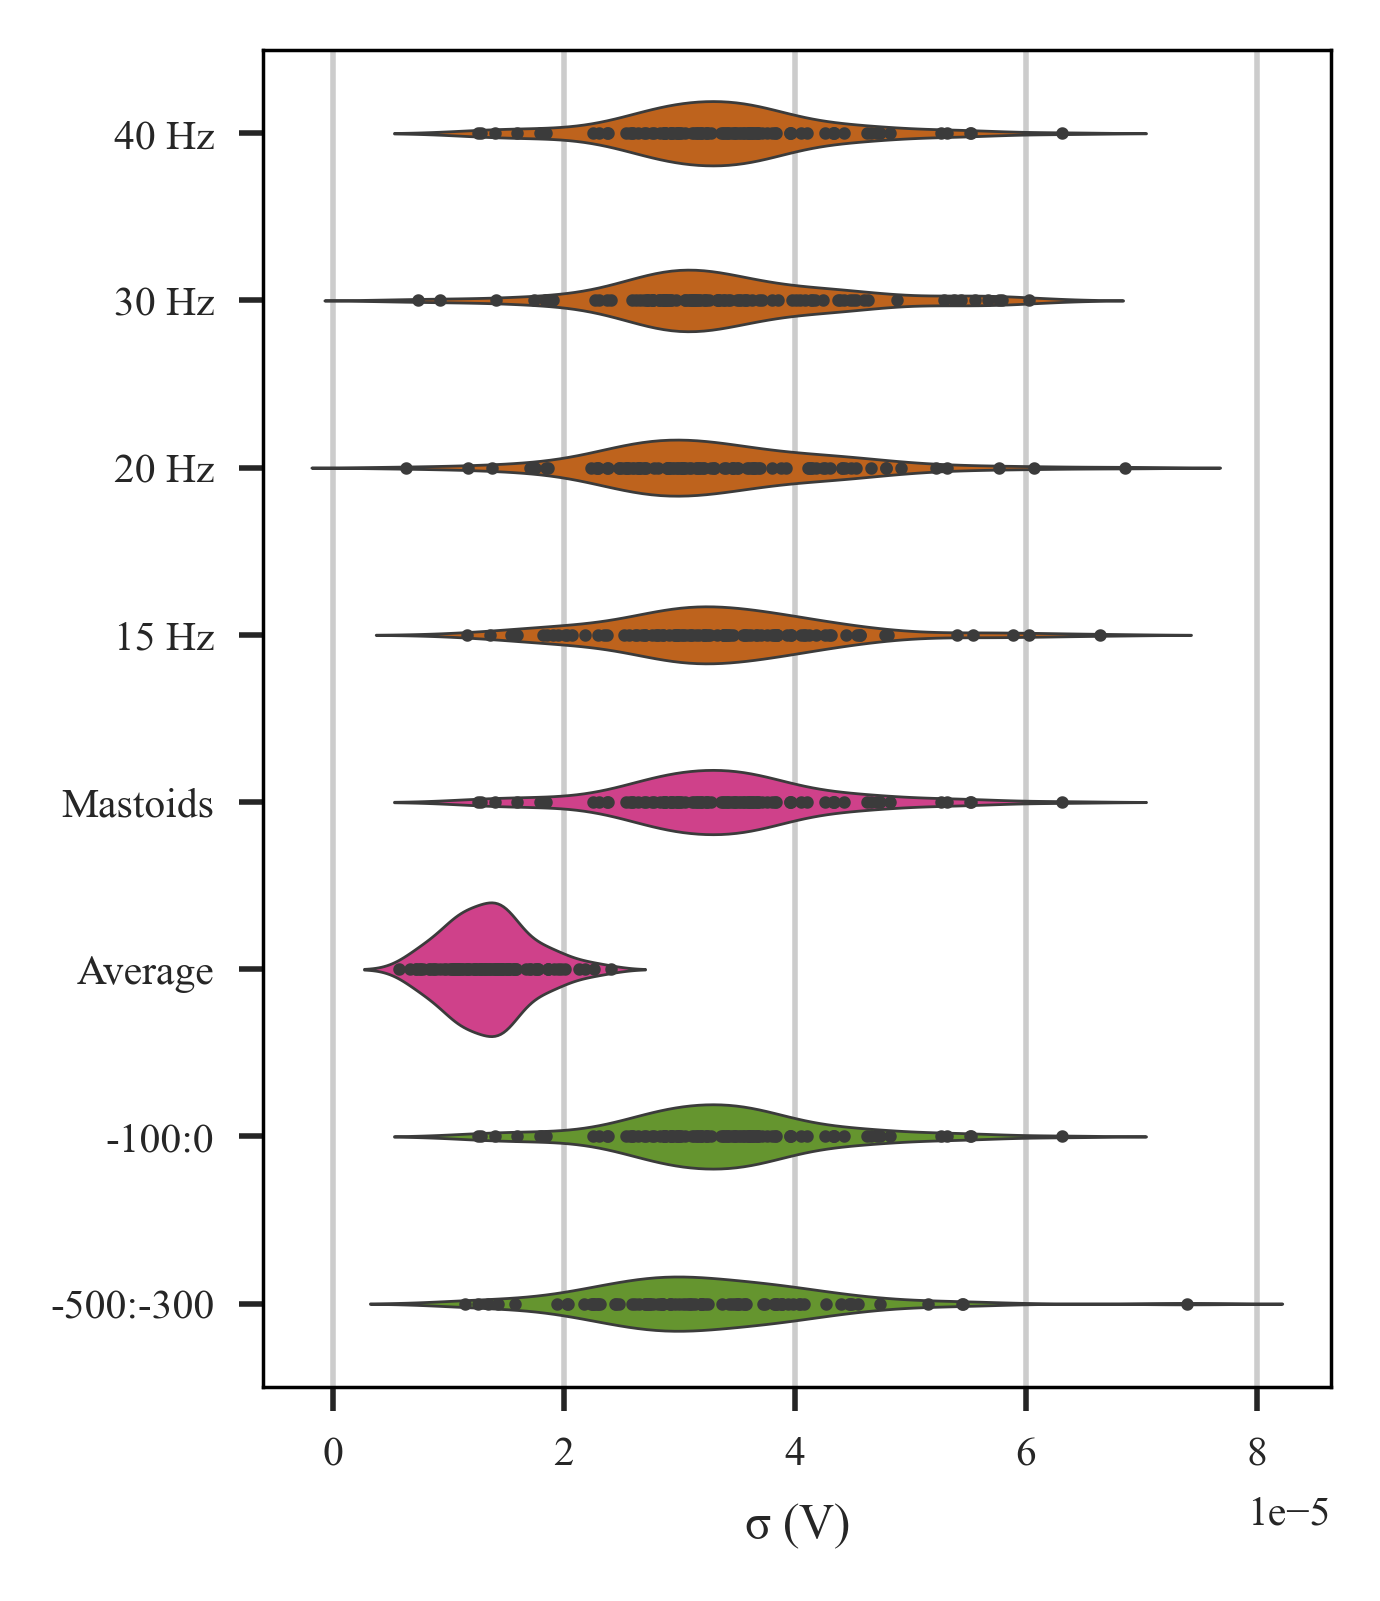

In [77]:
cm = 1/2.54
dpi = 500

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [7*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('Dark2')
colors = [
    pal.as_hex()[1], 
    pal.as_hex()[1], 
    pal.as_hex()[1], 
    pal.as_hex()[1], 
    pal.as_hex()[3], 
    pal.as_hex()[3], 
    # pal.as_hex()[2], 
    # pal.as_hex()[2],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
    pal.as_hex()[4],
    pal.as_hex()[4],
]


ax = sns.violinplot(
    x = 'values', 
    y = 'pipeline', 
    data = within_df, 
    orient='h',  
    inner="point", 
    cut=2, 
    # scale='count', 
    linewidth=0.4,
    palette=colors,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

ax.set_xlabel("$\mathregular{\sigma}$ (V)")
ax.set_ylabel('')

plt.show()

ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/within_subject_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

### Subject-level Internal Consistency

Calculated as subject-level dependability:

$$ \phi_{jk} = \frac{\sigma^2_p}{\sigma^2_p + \sigma^2_{ijk} / n_{ijk}}$$

In [88]:
consistency_df = pd.DataFrame({'pipeline': [], 'internal_variance': []})

In [89]:
for pipeline in between_df['pipeline'].unique().tolist():
    
    between_std = np.std(np.array(between_df.loc[between_df['pipeline'] == pipeline, 'values'].tolist()))                     
    within_list = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'values'].tolist())
    num_trials_list = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'num_trials'].tolist())
        
    for person_variance, num_trials in zip(within_list, num_trials_list):
        
        internal_consistency = between_std**2/(between_std**2 + (person_variance**2/num_trials))    
        data = {'pipeline' : pipeline,
                'internal_variance' : internal_consistency,
               }
    
        consistency_df = consistency_df.append(data, ignore_index = True)

In [ ]:
consistency_df = pd.DataFrame({'pipeline': [], 'internal_variance': []})

In [179]:
for pipeline in between_df['pipeline'].unique().tolist():
    
    between_std = np.std(np.array(between_df.loc[between_df['pipeline'] == pipeline, 'values'].tolist()))                     
    within_list = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'values'].tolist())
    num_trials_list = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'num_trials'].tolist())
        
    for person_variance, num_trials in zip(within_list, num_trials_list):
        
        internal_consistency = between_std**2/(between_std**2 + (person_variance**2/num_trials))    
        data = {'pipeline' : pipeline,
                'internal_variance' : internal_consistency,
               }
    
        consistency_df = consistency_df.append(data, ignore_index = True)

### Plot resulst of internal consistency tests

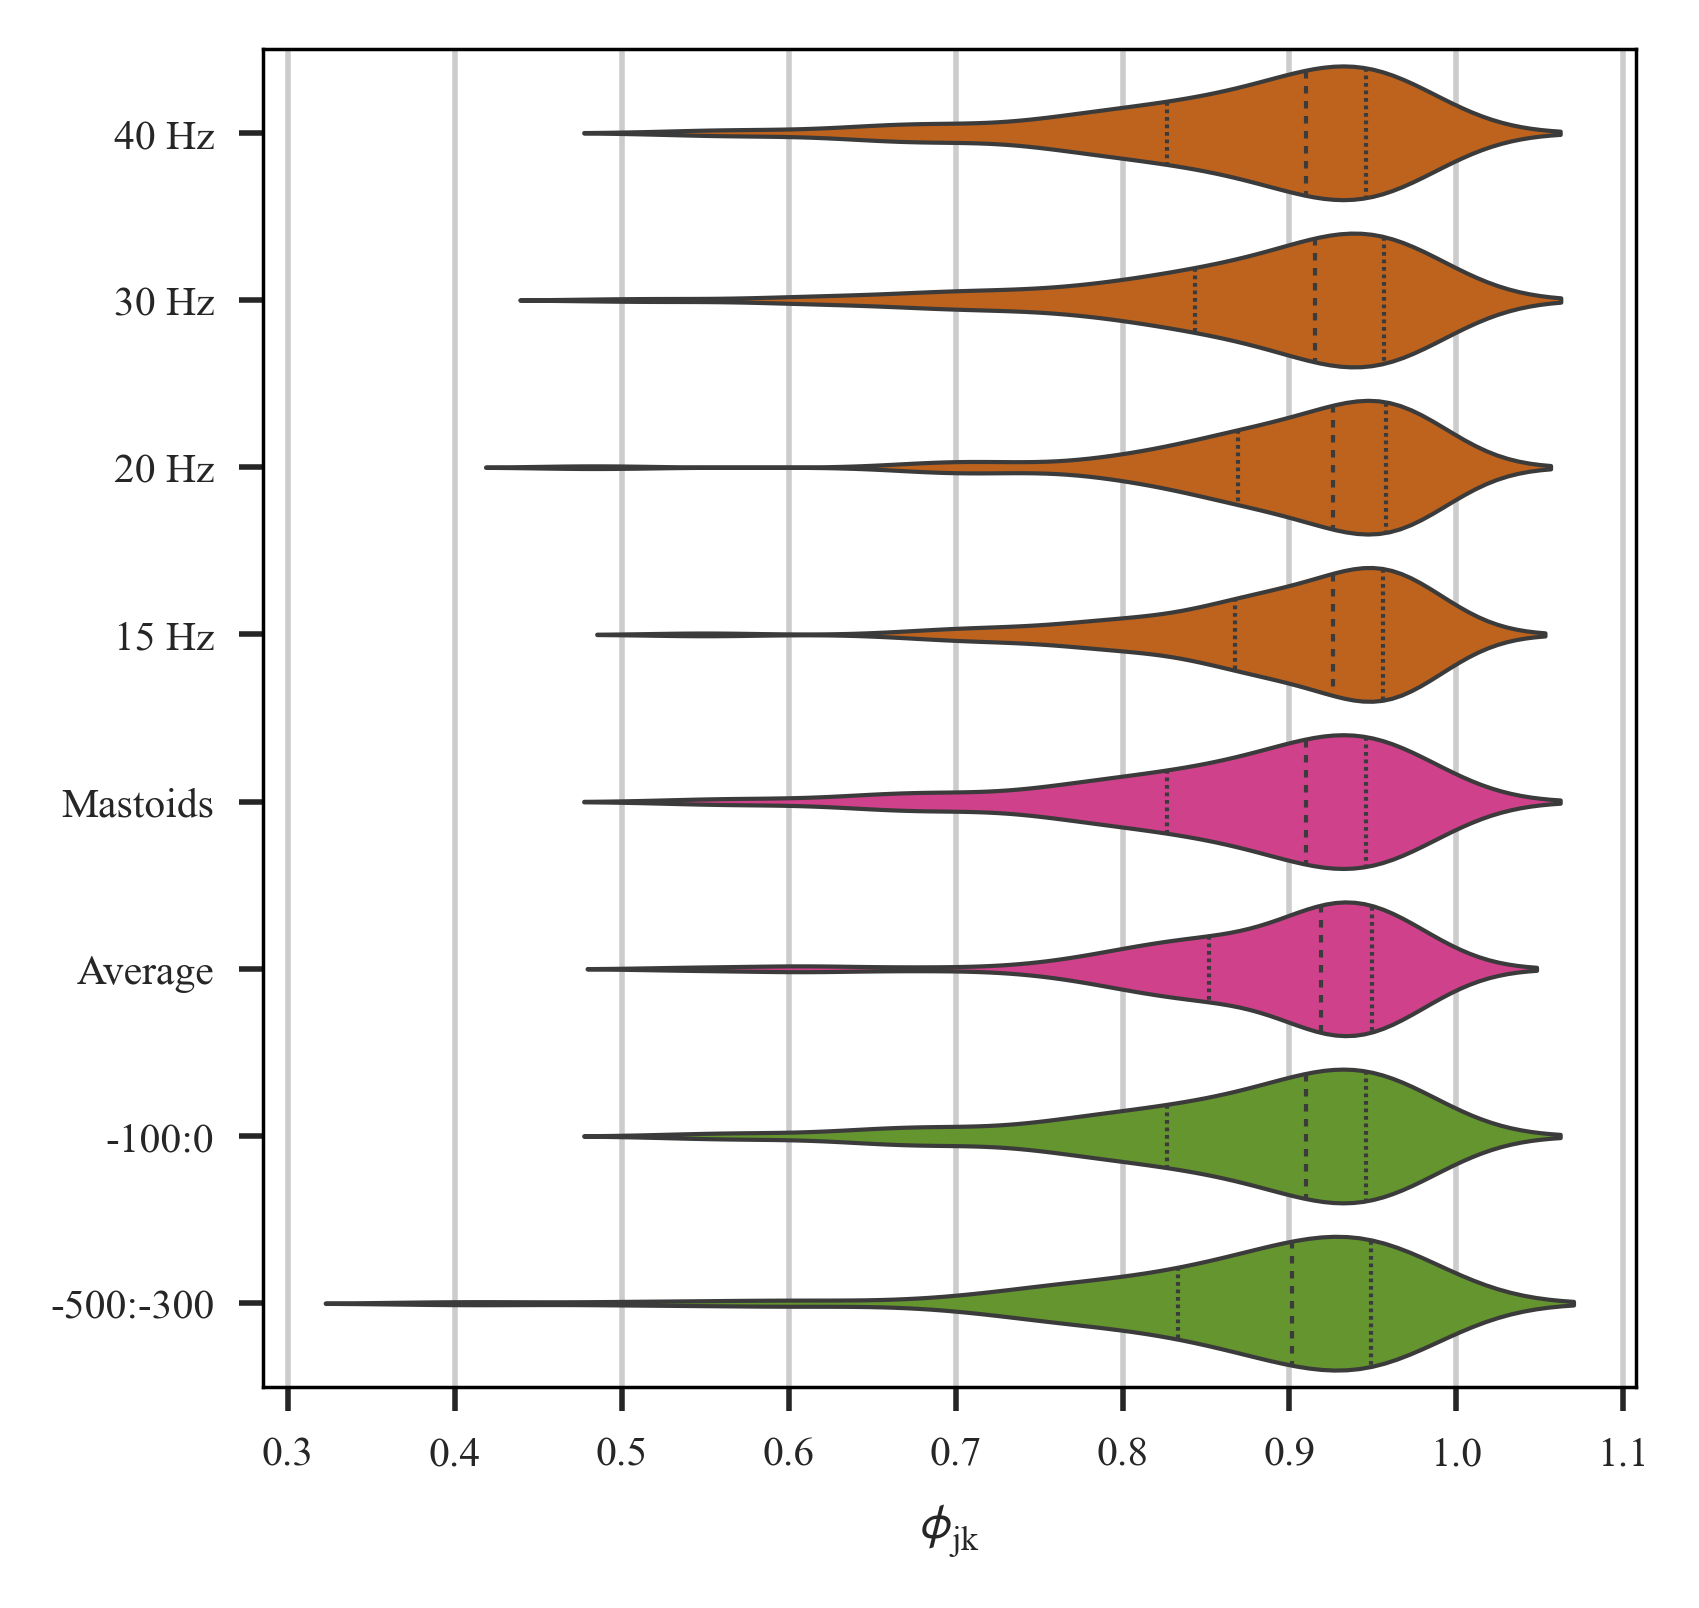

In [90]:
cm = 1/2.54
dpi = 500

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('Dark2')
colors = [
    pal.as_hex()[1], 
    pal.as_hex()[1], 
    pal.as_hex()[1], 
    pal.as_hex()[1], 
    pal.as_hex()[3], 
    pal.as_hex()[3], 
    # pal.as_hex()[2], 
    # pal.as_hex()[2],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
    # pal.as_hex()[4],
    pal.as_hex()[4],
    pal.as_hex()[4],
]


ax = sns.violinplot(
    x = 'internal_variance', 
    y = 'pipeline', 
    data = consistency_df, 
    orient='h',  
    inner="quartile", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
    palette=colors,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

ax.set_xlabel("$\mathregular{\phi_{jk}}$")
ax.set_ylabel('')

plt.show()

ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

---
## Variability of final pipelines (PCA components base ERN/Pe scores)

In [169]:
X_train_df_100 = epochs_df
X_test_df_100 = epochs_test_df

In [170]:
df_dict = {
    "train": X_train_df_100,
    "test": X_test_df_100
}

In [171]:
conditions = ['ern', 'pe']

### Within-subject Variability (SD)

In [172]:
within_df = pd.DataFrame({'pipeline': [], 'values': []})

In [173]:
for item in df_dict.items():
    for condition in conditions:
        rois = [
            ["Fpz","AFz","Fz", "FCz", "C1","Cz","C2","CPz","P1","Pz", "P2", ],
            ["Fpz","AFz","Fz", "FC1", "FCz", "FC2","C1","Cz","C2","CP1", "CPz", "CP2","P1","Pz", "P2"], 
        ] if condition == 'pe' else [["Fpz", "AFz","Fz","FCz","Cz","CPz","P1", "Pz", "P2"],
         ["Fpz", "AFz","F1", "Fz", "F2","FCz","C1", "Cz", "C2","CPz","P1", "Pz", "P2",]
        ]
        roi_num = 1 if condition == 'ern' else 3
        for index, roi in enumerate(rois): 
            X_df_100copy = pd.DataFrame(copy.deepcopy(item[1].to_dict()))
                
            pre_pip_for_spatial_filter = Pipeline([
                ("channels_extraction",PickChannels(channels_list = roi)),
                ("average", Evoked()),
                ('extract_averaged_data', ExtractData()),
                ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
                ("spatial_filter",PCA(n_components=4, random_state=random_state)),
            ]).fit(X_df_100copy)

            spatial_filter = pre_pip_for_spatial_filter['spatial_filter']
            X_df_100copy = pd.DataFrame(copy.deepcopy(item[1].to_dict()))
    
            pipeline_name = f'{condition}-ROI {index+roi_num} {item[0]}'
                
            for i in range(0,len(X_df_100copy)):

                X = X_df_100copy[i:i+1]
                
                x_pre = Pipeline([
                        ("channels_extraction",PickChannels(channels_list=roi)),
                        ('extract_data', ExtractDataEpochs()),
                ]).fit_transform(X) 
                
                x_pre = x_pre[0] 
                

                x_pre_pre = Pipeline([
                        ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
                        ("spatial_filter", spatial_filter),
                        ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=181)),
                        ("lowpass_filter", LowpassFilter()),
                        ("binning", BinTransformer(step=12)),
                        ("centering", CenteredSignalAfterBaseline3())]).transform(x_pre)


                ern_features = Pipeline(steps=[
                                                ("ern_data_extraction", ErnTransformer()),
                                                ("ern_amplitude", ErnAmplitude2()),
                                ])


                pe_features = Pipeline(steps = [
                                                ("pe_data_extraction", PeTransformer(start_pe_bin=3, stop_pe_bin=8)),
                                                ("pe_amplitude", ErnAmplitude2()),
                                ])

                ern_pe_features = FeatureUnion([("pe_features", pe_features)]) if condition == 'pe' else FeatureUnion([("ern_features", ern_features)])


                this_x = Pipeline([
                        ("features", ern_pe_features),
                    ]).fit_transform(x_pre_pre)

                
                f_vector = np.sum(this_x*1000000, axis=1)

                f_variance = np.std(f_vector.flatten())

                data = {'pipeline' : pipeline_name,
                        'values' : f_variance,
                        'num_trials': len(f_vector),
                       }

                within_df = within_df.append(data, ignore_index = True)

(96, 9, 181)
(96, 13, 181)
(96, 11, 181)
(96, 15, 181)
(34, 9, 181)
(34, 13, 181)
(34, 11, 181)
(34, 15, 181)


In [174]:
within_df.head()

,pipeline,values,num_trials
0,ern-ROI 1 train,9.787843,6.0
1,ern-ROI 1 train,23.189474,6.0
2,ern-ROI 1 train,26.779320,5.0
3,ern-ROI 1 train,14.657184,33.0
4,ern-ROI 1 train,18.609013,6.0


In [95]:
within_df.to_csv(f"within_subject_variance.csv")

### Between-subject Variability (SD)

In [175]:
between_df = pd.DataFrame({'pipeline': [], 'values': []})

In [176]:
for item in df_dict.items():
    for condition in conditions:
        rois = [ 
            ["Fpz","AFz","Fz", "FCz", "C1","Cz","C2","CPz","P1","Pz", "P2", ],
            ["Fpz","AFz","Fz", "FC1", "FCz", "FC2","C1","Cz","C2","CP1", "CPz", "CP2","P1","Pz", "P2"],
        ] if condition == 'pe' else [["Fpz", "AFz","Fz","FCz","Cz","CPz","P1", "Pz", "P2"],
         ["Fpz", "AFz","F1", "Fz", "F2","FCz","C1", "Cz", "C2","CPz","P1", "Pz", "P2",]
        ]
        roi_num = 1 if condition == 'ern' else 3
        
        for index, roi in enumerate(rois): 
            X_df_100copy = pd.DataFrame(copy.deepcopy(item[1].to_dict()))

            pipeline_name = f'{condition}-ROI {index+roi_num} {item[0]}'

            ern_features = Pipeline(steps=[
                                            ("ern_data_extraction", ErnTransformer()),
                                            ("ern_amplitude", ErnAmplitude2()),
                            ])


            pe_features = Pipeline(steps = [
                                            ("pe_data_extraction", PeTransformer(start_pe_bin=3, stop_pe_bin=9)),
                                            ("pe_amplitude", ErnAmplitude2()),
                            ])

            ern_pe_features = FeatureUnion([("pe_features", pe_features)]) if condition == 'pe' else FeatureUnion([("ern_features", ern_features)])

            x_pre = Pipeline([
                        ("channels_extraction",PickChannels(channels_list=roi)),
                        ("average", Evoked()),
                        ('extract_data', ExtractData()),
                        ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
                        ("spatial_filter",PCA(n_components=4, random_state=random_state)),
                        ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=181)),
                        ("lowpass_filter", LowpassFilter()),
                        ("binning", BinTransformer(step=12)),
                        ("centering", CenteredSignalAfterBaseline3()),
                        ("features", ern_pe_features),
            ]).fit_transform(X_df_100copy)

            x_feature_100_sf_between = np.sum(x_pre*1000000, axis=1)
            x_100_std_sf_between = np.std(x_feature_100_sf_between, axis=0)

            values = x_feature_100_sf_between.flatten().tolist()
            names = [pipeline_name] * len(x_feature_100_sf_between)

            temp_df = pd.DataFrame(zip(names, values), columns=['pipeline', 'values'])

            between_df = between_df.append(temp_df, ignore_index=True)

(96, 9, 181)
(96, 13, 181)
(96, 11, 181)
(96, 15, 181)
(34, 9, 181)
(34, 13, 181)
(34, 11, 181)
(34, 15, 181)


In [177]:
between_df.head()

,pipeline,values
0,ern-ROI 1 train,28.460276
1,ern-ROI 1 train,40.256081
2,ern-ROI 1 train,67.992433
3,ern-ROI 1 train,19.741685
4,ern-ROI 1 train,35.920835


In [99]:
between_df.to_csv(f"between_subject_variance.csv")

### Subject-level Internal Consistency

Calculated as subject-level dependability:

$$ \phi_{jk} = \frac{\sigma^2_p}{\sigma^2_p + \sigma^2_{ijk} / n_{ijk}}$$

In [ ]:
consistency_df = pd.DataFrame({'pipeline': [], 'internal_variance': []})

In [179]:
for pipeline in between_df['pipeline'].unique().tolist():
    
    between_std = np.std(np.array(between_df.loc[between_df['pipeline'] == pipeline, 'values'].tolist()))                     
    within_list = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'values'].tolist())
    num_trials_list = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'num_trials'].tolist())
        
    for person_variance, num_trials in zip(within_list, num_trials_list):
        
        internal_consistency = between_std**2/(between_std**2 + (person_variance**2/num_trials))    
        data = {'pipeline' : pipeline,
                'internal_variance' : internal_consistency,
               }
    
        consistency_df = consistency_df.append(data, ignore_index = True)

In [180]:
consistency_df.head()

,pipeline,internal_variance
0,ern-ROI 1 train,0.935408
1,ern-ROI 1 train,0.720667
2,ern-ROI 1 train,0.617179
3,ern-ROI 1 train,0.972617
4,ern-ROI 1 train,0.800254


In [103]:
consistency_df.to_csv(f"internal_consistency.csv")

### Variability and Internal Consistency plots

#### ERN

In [185]:
condition = 'pe'

In [182]:
names_dict = {
    "ern-ROI 1 train": "ROI 1 Internal",
    "ern-ROI 2 train": "ROI 2 Internal",
    "ern-ROI 1 test": "ROI 1 External",
    "ern-ROI 2 test": "ROI 2 External",
}

In [183]:
current_internal_df = current_internal_df.replace(names_dict)
current_between_df = current_between_df.replace(names_dict)
current_within_df = current_within_df.replace(names_dict)

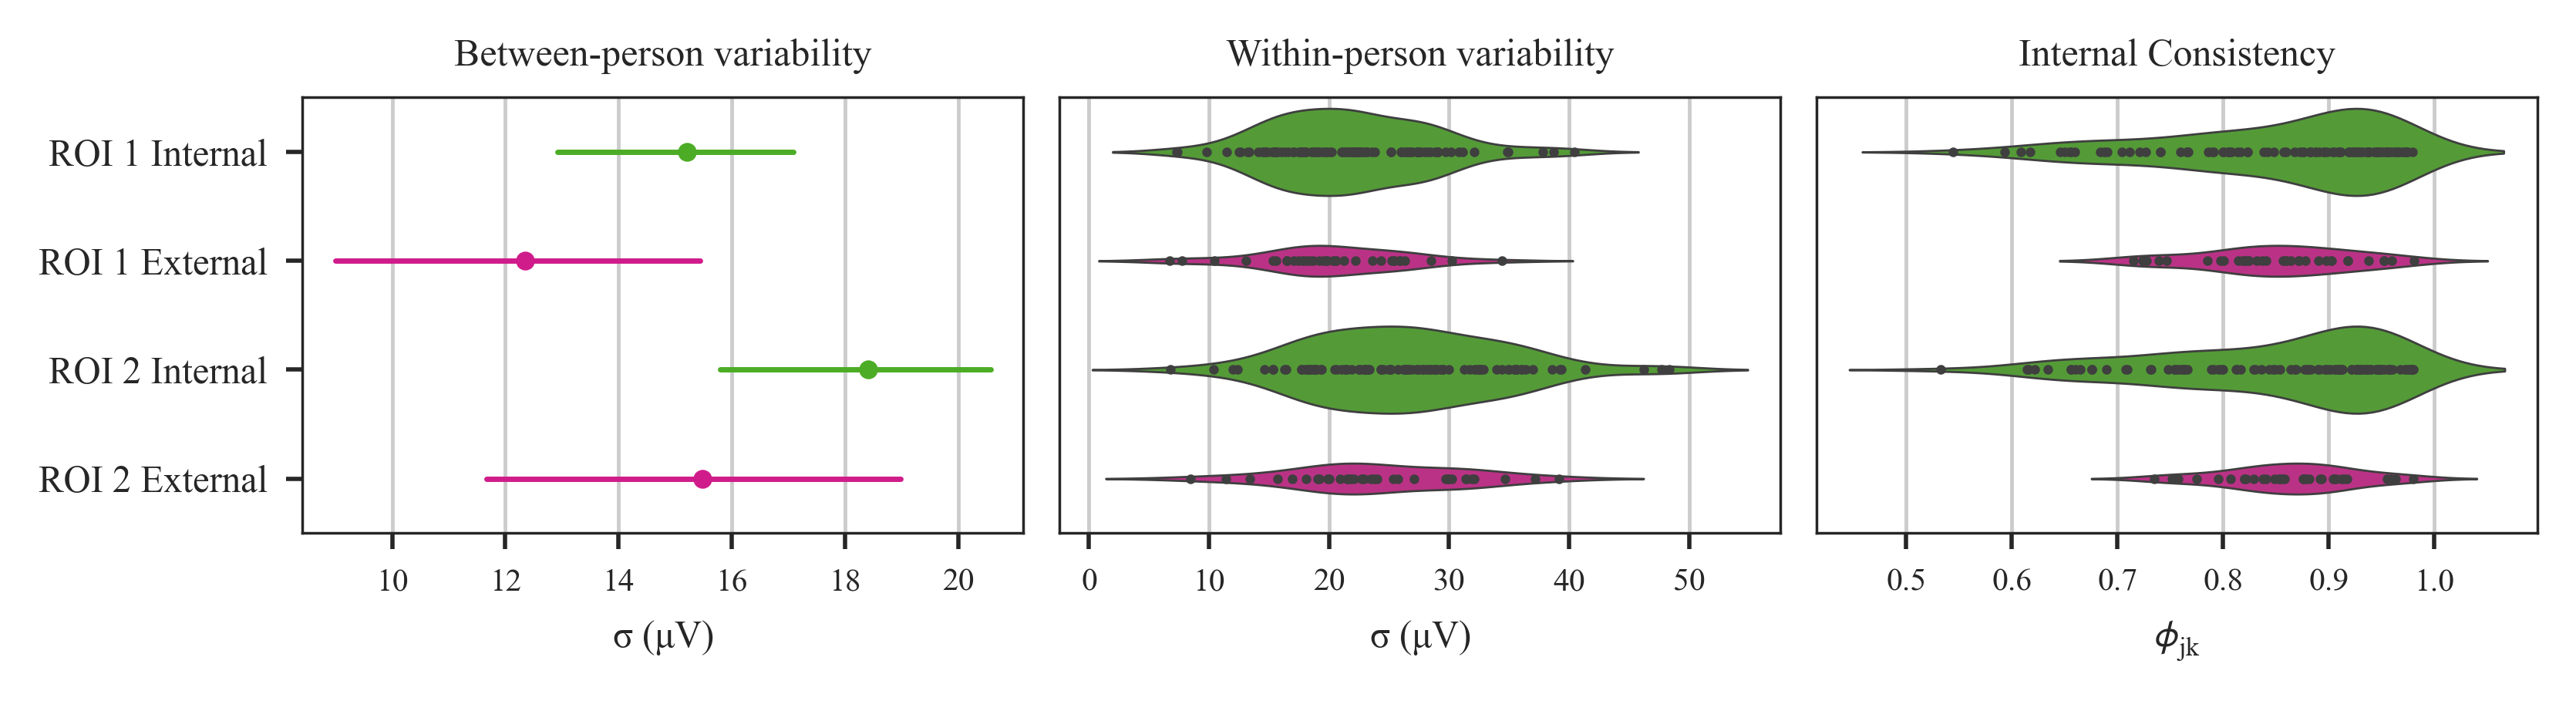

In [184]:
cm = 1/2.54
dpi = 500

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 6
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


# pink and green
custom_palette = ["#4dac26",  '#d01c8b', "#4dac26", '#d01c8b']
sns.set_palette(sns.color_palette(custom_palette))


fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, squeeze=True, gridspec_kw={'wspace':0.05})


#######BETWEEN SUBJECT##########################
ax_between = sns.pointplot(
    data = current_between_df, 
    x = 'values', 
    y='pipeline', 
    hue='pipeline',  
    order=['ROI 1 Internal', 'ROI 1 External', 'ROI 2 Internal', 'ROI 2 External'], 
    orient='h', 
    join=False, 
    estimator=np.std, 
    ci=95,
    capsize=0, 
    errwidth=1,   
    scale = 0.4, 
    legend=False,
    palette=sns.color_palette(["#4dac26", "#4dac26", '#d01c8b', '#d01c8b']),
    ax=axs[0],
)

ax_between.set_xlabel("$\mathregular{\sigma}$ (μV)")
ax_between.set_ylabel('')
ax_between.legend([],[], frameon=False)
ax_between.tick_params(axis='both', which='major', bottom=True, left = True, direction="out", length=3, width=0.8, grid_linewidth=0.7)
ax_between.set(title='Between-person variability')

####################################################

#######WITHIN SUBJECT##########################
ax_within = sns.violinplot(
    x = 'values', 
    y = 'pipeline', 
    data = current_within_df, 
    orient='h',  
    inner="point", 
    cut=2, 
    scale='count', 
    linewidth=0.4,
    order=['ROI 1 Internal', 'ROI 1 External', 'ROI 2 Internal', 'ROI 2 External'],
    ax=axs[1]
)

ax_within.set_xlabel("$\mathregular{\sigma}$ (μV)")

ax_within.set_ylabel('') 
ax_within.tick_params(axis='both', which='major', bottom=True, direction="out", length=3, width=0.8, grid_linewidth=0.7)
ax_within.set_title('Within-person variability')
####################################################


#######INTERNAL CONSISTENCY##########################
ax_internal = sns.violinplot(
    x = 'internal_variance', 
    y = 'pipeline', 
    data = current_internal_df, 
    orient='h', 
    inner="point", 
    scale='count', 
    linewidth=0.4,
    order=['ROI 1 Internal', 'ROI 1 External', 'ROI 2 Internal', 'ROI 2 External'],
    ax=axs[2]
)

ax_internal.set_xlabel("$\mathregular{\phi_{jk}}$")
ax_internal.set_ylabel('') 
ax_internal.tick_params(axis='both', which='major', bottom=True, direction="out", length=3, width=0.8, grid_linewidth=0.7)
ax_internal.set(title='Internal Consistency')
####################################################

# set figure size
fig.set_size_inches(19*cm, 3.8*cm)

# fig.savefig(f"../public_data/figures/variability/{condition}_internal_consistency_dpi_{dpi}.png",  bbox_inches='tight')

#### Pe

In [185]:
condition = 'pe'

In [186]:
current_internal_df = consistency_df[consistency_df['pipeline'].str.contains(condition)]
current_between_df = between_df[between_df['pipeline'].str.contains(condition)]
current_within_df = within_df[within_df['pipeline'].str.contains(condition)]

In [187]:
names_dict = {
    "pe-ROI 3 train": "ROI 3 Internal",
    "pe-ROI 4 train": "ROI 4 Internal",
    "pe-ROI 3 test": "ROI 3 External",
    "pe-ROI 4 test": "ROI 4 External",
}

In [188]:
current_internal_df = current_internal_df.replace(names_dict)
current_between_df = current_between_df.replace(names_dict)
current_within_df = current_within_df.replace(names_dict)

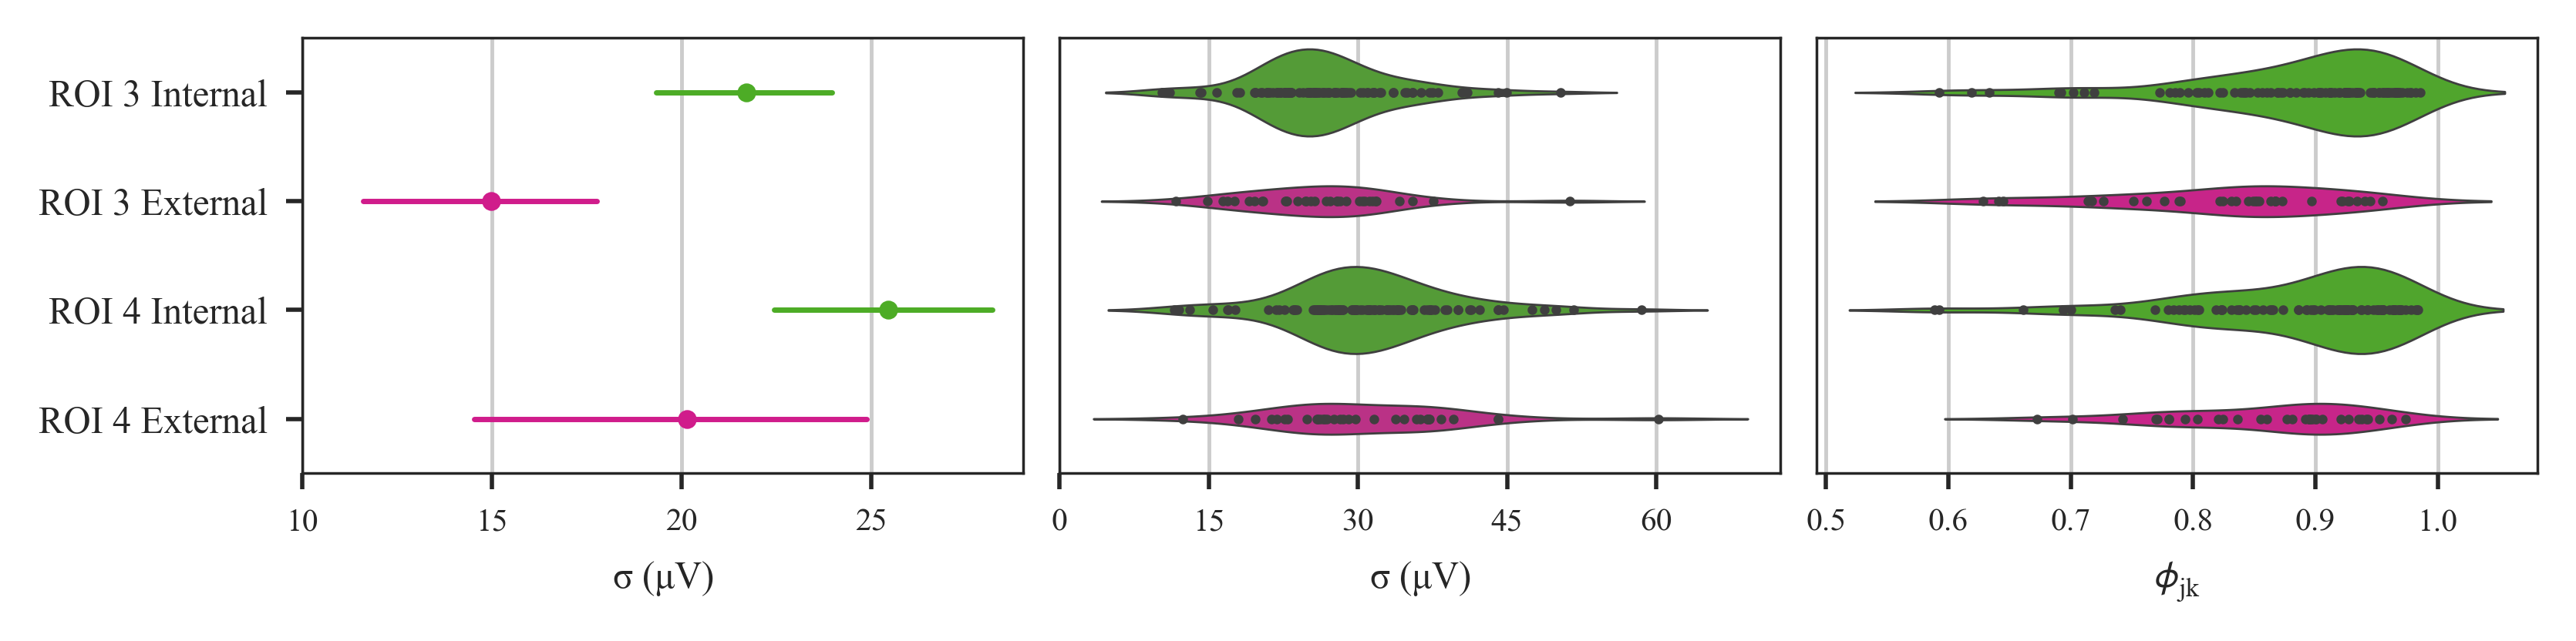

In [189]:
cm = 1/2.54
dpi = 500

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


# pink and green
custom_palette = ["#4dac26",  '#d01c8b', "#4dac26", '#d01c8b']
sns.set_palette(sns.color_palette(custom_palette))


fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, squeeze=True, gridspec_kw={'wspace':0.05})


#######BETWEEN SUBJECT##########################
ax_between = sns.pointplot(
    data = current_between_df, 
    x = 'values', 
    y='pipeline', 
    hue='pipeline',  
    order=['ROI 3 Internal', 'ROI 3 External', 'ROI 4 Internal', 'ROI 4 External'], 
    orient='h', 
    join=False, 
    estimator=np.std, 
    ci=95,
    capsize=0, 
    errwidth=1,   
    scale = 0.4, 
    legend=False,
    ax=axs[0],
    palette=sns.color_palette(["#4dac26", "#4dac26", '#d01c8b', '#d01c8b']),

)

ax_between.set_xlabel("$\mathregular{\sigma}$ (μV)")
ax_between.set_ylabel('')
ax_between.legend([],[], frameon=False)
ax_between.tick_params(axis='both', which='major', bottom=True, left = True, direction="out", length=3, width=0.8, grid_linewidth=0.7)
ax_between.xaxis.set_ticks(np.arange(10, 30, 5))

####################################################

#######WITHIN SUBJECT##########################
ax_within = sns.violinplot(
    x = 'values', 
    y = 'pipeline', 
    data = current_within_df, 
    orient='h',  
    inner="point", 
    cut=2, 
    scale='count', 
    linewidth=0.4,
    order=['ROI 3 Internal', 'ROI 3 External', 'ROI 4 Internal', 'ROI 4 External'], 
    ax=axs[1]
)

ax_within.set_xlabel("$\mathregular{\sigma}$ (μV)")
ax_within.set_ylabel('') 
ax_within.tick_params(axis='both', which='major', bottom=True, direction="out", length=3, width=0.8, grid_linewidth=0.7)
ax_within.xaxis.set_ticks(np.arange(0, 61, 15))
####################################################


#######INTERNAL CONSISTENCY##########################
ax_internal = sns.violinplot(
    x = 'internal_variance', 
    y = 'pipeline', 
    data = current_internal_df, 
    orient='h', 
    inner="point", 
    scale='count', 
    linewidth=0.4,
    order=['ROI 3 Internal', 'ROI 3 External', 'ROI 4 Internal', 'ROI 4 External'], 
    ax=axs[2],
    saturation=0.9,
    
)

ax_internal.set_xlabel("$\mathregular{\phi_{jk}}$")
ax_internal.set_ylabel('') 
ax_internal.tick_params(axis='both', which='major', bottom=True, direction="out", length=3, width=0.8, grid_linewidth=0.7)
####################################################


# set figure size
fig.set_size_inches(19*cm, 3.8*cm)

# fig.savefig(f"../public_data/figures/variability/{condition}_internal_consistency_dpi_{dpi}.png",  bbox_inches='tight')